--- Starting K-Fold Cross-Validation for TCN Model ---

--- Fold 1/5 ---
Epoch 1/30
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0417 - val_loss: 0.0015
Epoch 2/30
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0021 - val_loss: 6.8404e-04
Epoch 3/30
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0015 - val_loss: 6.9300e-04
Epoch 4/30
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0013 - val_loss: 6.9712e-04
Epoch 5/30
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0012 - val_loss: 5.0144e-04
Epoch 6/30
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0012 - val_loss: 7.0801e-04
Epoch 7/30
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0012 - val_loss: 5.9309e-04
Epoch 8/30
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0011 - val_loss: 3.9523e-04
Epoch 9/30
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0010 - val_loss: 4.3214e-04
Epoch 10/30
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0010 - val_loss: 4

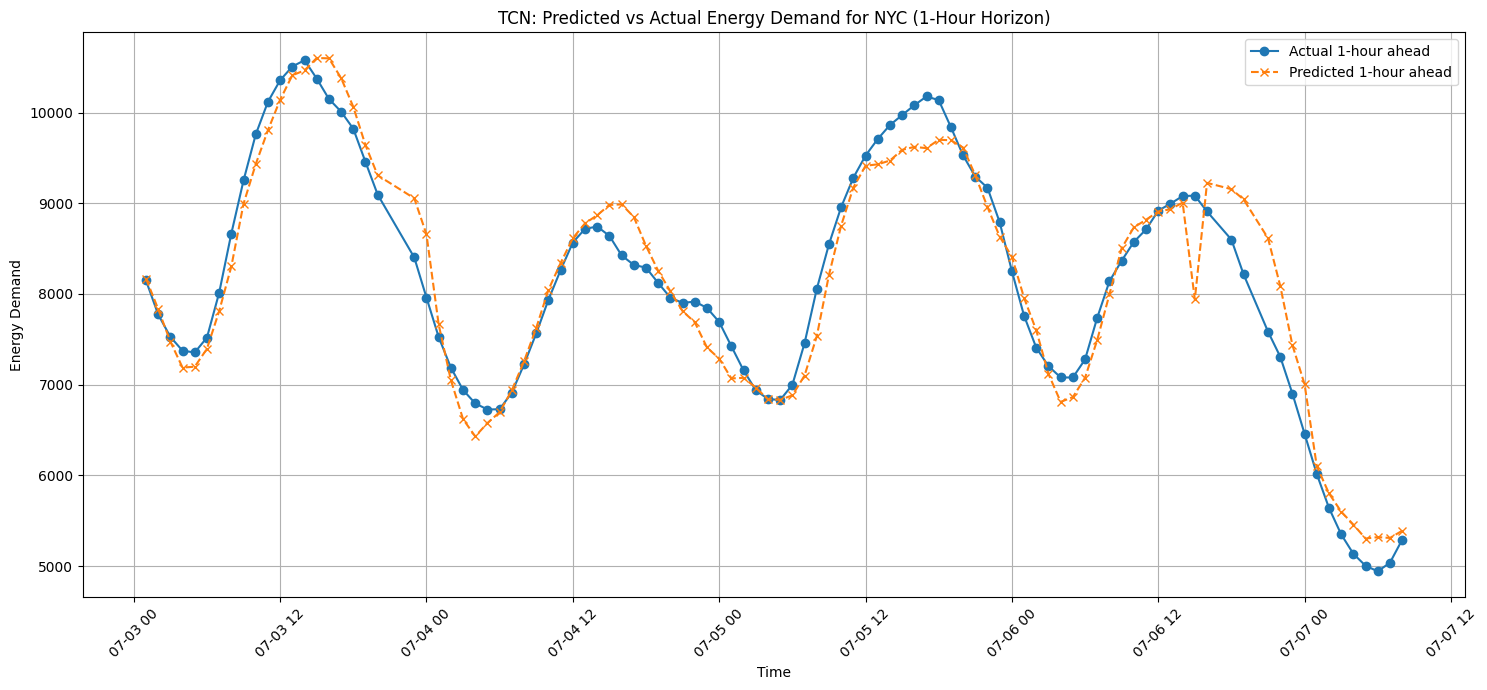

In [1]:
# NYC Energy Demand Forecasting with TCN (Updated)
#
# This script builds and evaluates a Temporal Convolutional Network (TCN) model
# for energy demand forecasting in NYC.
#
# Updates from original version:
# - Multi-Horizon Forecasting: Predicts energy demand for 1, 6, 12, and 24 hours ahead.
# - Additional Metrics: Evaluation includes MAE, MSE, RMSE, R², and MAPE for each forecast horizon.

#REMOVED TEMP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv1D, Activation, SpatialDropout1D, Lambda, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf

# --- 1. Data Loading and Feature Engineering ---
# Load the dataset
# Make sure to replace 'New York City.xlsx' with the correct path if the file is not in the same directory.
try:
    df = pd.read_excel('New York City.xlsx')
except FileNotFoundError:
    print("Error: 'New York City.xlsx' not found. Please ensure the dataset is in the correct directory.")
    exit()

df.dropna(inplace=True)

# Create time-based features
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['DayOfWeek'] = pd.to_datetime(df['Time']).dt.dayofweek
df['Month'] = pd.to_datetime(df['Time']).dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Create lag features
for lag in range(1, 25):
    df[f'Lag_{lag}'] = df['EnergyDemand'].shift(lag)

# Create rolling window features
df['Temp_RollingMean_24'] = df['Temperature'].rolling(window=24).mean()
df['Temp_RollingStd_24'] = df['Temperature'].rolling(window=24).std()

# Create interaction features
df['Temp_Humidity_Interaction'] = df['Temperature'] * df['RelativeHumidity']

df.dropna(inplace=True)

# Define features and target
features = df[['DewPoint', 'RelativeHumidity', 'Precipitation', 'WindSpeed', 'Pressure',
               'Hour', 'DayOfWeek', 'Month', 'IsWeekend',
               'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10',
               'Lag_11', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15', 'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19',
               'Lag_20', 'Lag_21', 'Lag_22', 'Lag_23', 'Lag_24',
               'Temp_Humidity_Interaction']].values
energy_demand = df['EnergyDemand'].values.reshape(-1, 1)
dates = df['Time'].values

# Scale features and target
scaler_features = MinMaxScaler()
scaler_energy = MinMaxScaler()
features_normalized = scaler_features.fit_transform(features)
energy_demand_normalized = scaler_energy.fit_transform(energy_demand)

# --- 2. Sequence Creation for Time Series Forecasting ---
def create_sequences(data, target, dates, seq_length, horizons):
    """
    Creates sequences of data for time series forecasting.
    """
    sequences = []
    targets = []
    sequence_dates = []
    for i in range(len(data) - seq_length - max(horizons) + 1):
        seq = data[i:i+seq_length]
        target_seq = [target[i + seq_length + h - 1][0] for h in horizons]
        date_seq = dates[i+seq_length]
        sequences.append(seq)
        targets.append(target_seq)
        sequence_dates.append(date_seq)
    return np.array(sequences), np.array(targets), np.array(sequence_dates)

seq_length = 24
horizons = [1, 6, 12, 24]
X, y, dates_seq = create_sequences(features_normalized, energy_demand_normalized, dates, seq_length, horizons)

# --- 3. Model Definition, Training, and Evaluation ---
def residual_block(x, dilation_rate, nb_filters, kernel_size, dropout_rate=0.2):
    prev_x = x
    x = Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(dropout_rate)(x)
    x = Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(dropout_rate)(x)

    if prev_x.shape[-1] != x.shape[-1]:
        prev_x = Conv1D(filters=nb_filters, kernel_size=1, padding='same')(prev_x)

    x = Add()([prev_x, x])
    return x

def create_tcn_model(input_shape, nb_filters, kernel_size, dilations, nb_stacks, num_horizons):
    input_layer = Input(shape=input_shape)
    x = input_layer
    for _ in range(nb_stacks):
        for dilation_rate in dilations:
            x = residual_block(x, dilation_rate, nb_filters, kernel_size)
    x = Lambda(lambda tt: tt[:, -1, :])(x)
    output_layer = Dense(num_horizons)(x)
    model = Model(input_layer, output_layer)
    return model

kf = KFold(n_splits=5, shuffle=False)
all_metrics = {h: {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': []} for h in horizons}

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

result_df = pd.DataFrame()

print("--- Starting K-Fold Cross-Validation for TCN Model ---")
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\n--- Fold {fold+1}/5 ---")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dates_test = dates_seq[test_index]

    model = create_tcn_model(
        input_shape=(seq_length, X.shape[2]),
        nb_filters=64,
        kernel_size=2,
        dilations=[1, 2, 4, 8, 16, 32],
        nb_stacks=1,
        num_horizons=len(horizons)
    )

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

    predictions_normalized = model.predict(X_test)
    predictions = scaler_energy.inverse_transform(predictions_normalized)
    y_test_original = scaler_energy.inverse_transform(y_test)

    for i, h in enumerate(horizons):
        mae = mean_absolute_error(y_test_original[:, i], predictions[:, i])
        mse = mean_squared_error(y_test_original[:, i], predictions[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_original[:, i], predictions[:, i])
        mape = mean_absolute_percentage_error(y_test_original[:, i], predictions[:, i])

        all_metrics[h]['mae'].append(mae)
        all_metrics[h]['mse'].append(mse)
        all_metrics[h]['rmse'].append(rmse)
        all_metrics[h]['r2'].append(r2)
        all_metrics[h]['mape'].append(mape)

    fold_results = pd.DataFrame({'Date': dates_test})
    for i, h in enumerate(horizons):
        fold_results[f'Actual_{h}h'] = y_test_original[:, i]
        fold_results[f'Predicted_{h}h'] = predictions[:, i]

    result_df = pd.concat([result_df, fold_results], ignore_index=True)

# --- 4. Display Results ---
print("\n--- Average Performance Metrics for TCN Model ---")
for h in horizons:
    print(f'\nHorizon: {h} hours')
    for metric_name, values in all_metrics[h].items():
        print(f'  Average {metric_name.upper()}: {np.mean(values):.4f}')

# Plot results for the 1-hour horizon as an example
print("\n--- Plotting Results for 1-Hour Horizon (First 100 Points) ---")
plt.figure(figsize=(15, 7))
plt.plot(result_df['Date'][:100], result_df['Actual_1h'][:100], label='Actual 1-hour ahead', marker='o', linestyle='-')
plt.plot(result_df['Date'][:100], result_df['Predicted_1h'][:100], label='Predicted 1-hour ahead', marker='x', linestyle='--')
plt.title('TCN: Predicted vs Actual Energy Demand for NYC (1-Hour Horizon)')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()